## Security Surveillance Anomaly Detection

Background: A large facility with security cameras wants to enhance its surveillance capabilities. Develop a video analytics solution to automatically detect unusual activities or anomalies in real-time, improving overall security.

Task:
- Design and implement video analytics algorithms for anomaly detection.
- Test the solution using historical data and fine-tune parameters for accuracy.
- Provide recommendations for response protocols based on detected anomalies.

#### About the dataset:
The dataset contains video of pedestrians on UCSD walkways, taken from a stationary camera. All videos are 8-bit grayscale, with dimensions 238 * 158 at 10 fps. This dataset is taken from kaggle the open source for datasets.

!pip install opencv-python

In [19]:
import cv2
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


#### Preprocess the Video Data: Load and Preprocess images using OpenCV

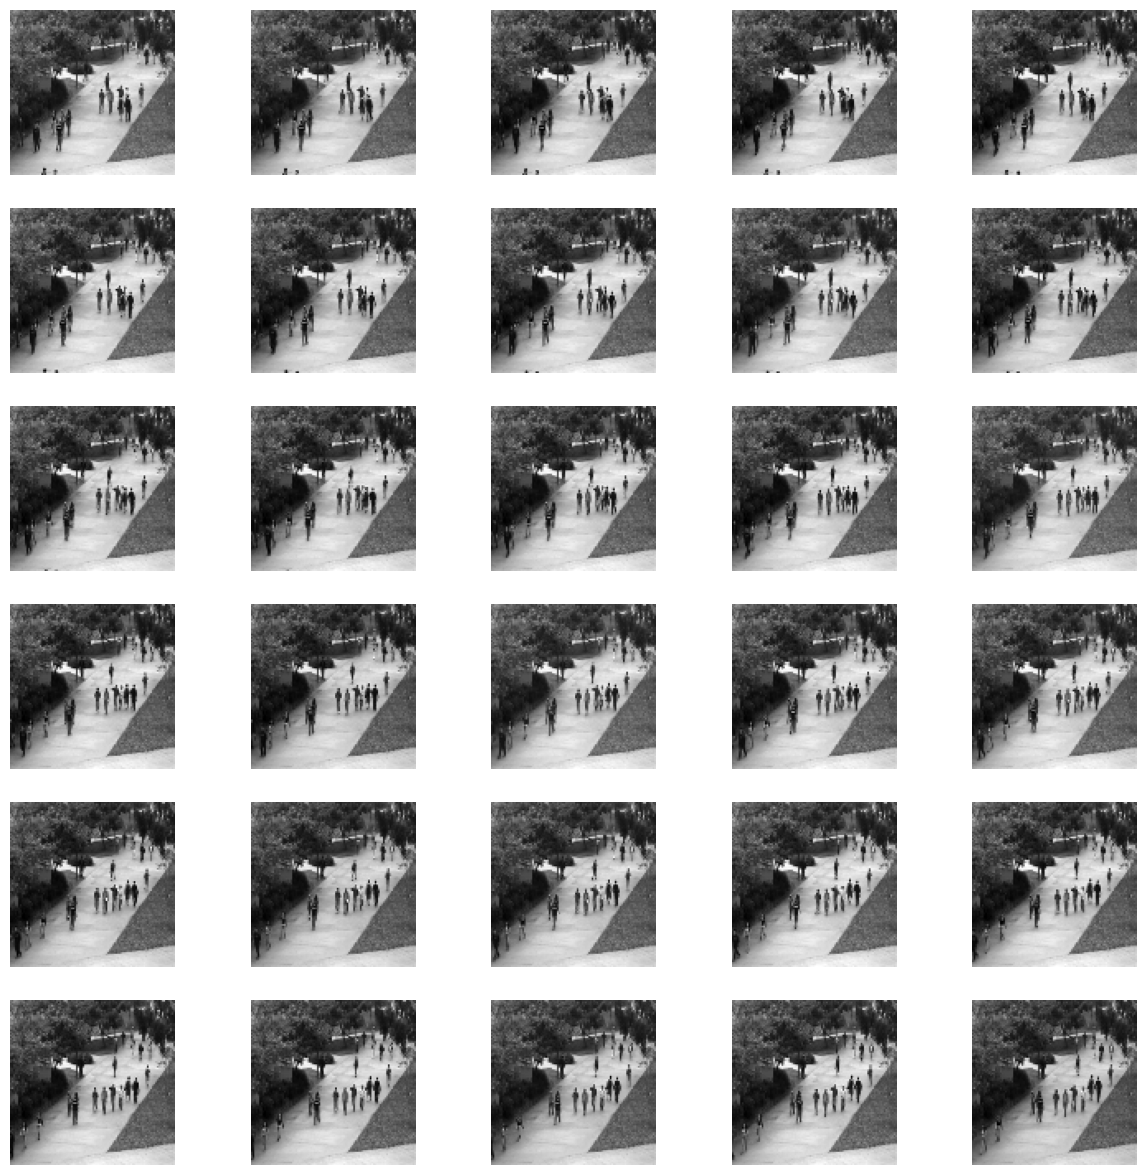

In [15]:
def load_and_preprocess_image_opencv(file_path):
    try:
        # Read the image in grayscale
        img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise ValueError("Image not loaded; possible bad file")
        # Resize the image
        img = cv2.resize(img, (100, 100))
        # Normalize the image
        img_array = img.astype(np.float32) / 255.0
        # Expand the dimensions to add the channel
        img_array = np.expand_dims(img_array, axis=-1)
        return img_array, img_array
    except Exception as e:
        print(f"Error processing image {file_path}: {e}")
        # Return a zero-filled array to maintain consistency
        return np.zeros((100, 100, 1), dtype=np.float32), np.zeros((100, 100, 1), dtype=np.float32)

# Function to create dataset from a directory
def create_dataset(root_dir, batch_size):
    file_paths = glob.glob(os.path.join(root_dir, 'Train', '*', '*.tif'))
    dataset = tf.data.Dataset.from_tensor_slices(file_paths)
    
    def _load_image(file_path):
        file_path = file_path.numpy().decode("utf-8")  # Decode from tensor to string
        image, _ = load_and_preprocess_image_opencv(file_path)
        return tf.convert_to_tensor(image, dtype=tf.float32), tf.convert_to_tensor(image, dtype=tf.float32)
    
    def load_image_wrapper(file_path):
        # Use tf.py_function to wrap _load_image function
        image, label = tf.py_function(_load_image, [file_path], [tf.float32, tf.float32])
        # Set the shape explicitly
        image.set_shape((100, 100, 1))
        label.set_shape((100, 100, 1))
        return image, label
    
    dataset = dataset.map(load_image_wrapper, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.filter(lambda x, y: tf.reduce_sum(x) > 0)  # Optionally filter out all-zero images
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Adjust `root_dir` to your correct directory path
batch_size = 32
root_dir = r'D:\Deep-Learning\UCSD_Anomaly_Dataset.v1p2\UCSDped1'
train_dataset = create_dataset(root_dir, batch_size)

# Function to show batch of images
def show_batch(image_batch):
    plt.figure(figsize=(15, 15))
    for n in range(min(len(image_batch), 30)):  # Show a maximum of 30 images
        ax = plt.subplot(6, 5, n + 1)  # 6 rows and 5 columns
        plt.imshow(image_batch[n].squeeze(), cmap='gray')  # Assuming grayscale images
        plt.axis('off')
    plt.show()

# Debugging: Show first batch
for images, _ in train_dataset.take(1):
    show_batch(images.numpy())

#### Using Pre-trained Model for Feature Extraction

In [17]:
# Simplified autoencoder model
def build_simplified_autoencoder(input_shape):
    input_img = Input(shape=input_shape)

    # Encoder
    x = Conv2D(16, (3, 3), padding='same')(input_img)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(8, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = Conv2D(8, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = UpSampling2D((2, 2))(x)

    x = Conv2D(16, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = UpSampling2D((2, 2))(x)

    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)  # Ensure the final layer uses sigmoid for [0, 1] range

    # Autoencoder Model
    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

    return autoencoder

# Define input shape
input_shape = (100, 100, 1)  # Modify as needed

# Build and compile the simplified autoencoder
autoencoder = build_simplified_autoencoder(input_shape)

# Train the model
history = autoencoder.fit(
    train_dataset,
    epochs=10
)

Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 114ms/step - loss: 0.0549
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - loss: 0.0210
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - loss: 0.0093
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - loss: 0.0083
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - loss: 0.0076
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - loss: 0.0071
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - loss: 0.0067
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - loss: 0.0065
Epoch 9/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - loss: 0.0062
Epoch 10/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - loss: 0.0059


#### Test Dataset load

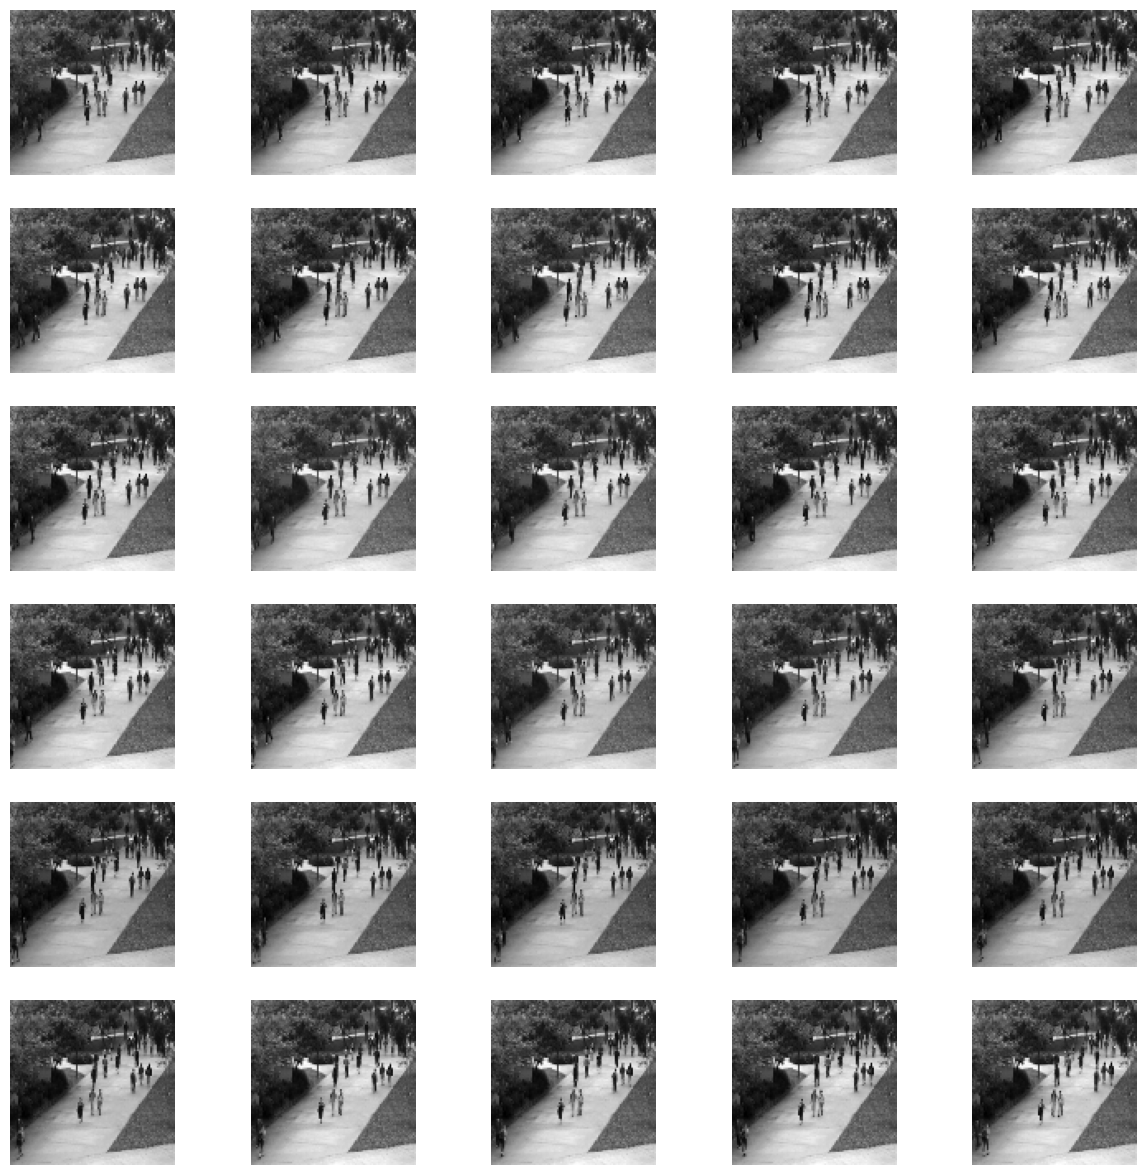

In [31]:
# Function to create test dataset
def create_dataset_test(root_dir, batch_size):
    file_paths = glob.glob(os.path.join(root_dir, 'Test', '*', '*.tif'))
    dataset = tf.data.Dataset.from_tensor_slices(file_paths)

    def _load_image(file_path):
        file_path = file_path.numpy().decode("utf-8")  # Decode from tensor to string
        image, _ = load_and_preprocess_image_opencv(file_path)
        return tf.convert_to_tensor(image, dtype=tf.float32), tf.convert_to_tensor(image, dtype=tf.float32)

    def load_image_wrapper(file_path):
        # Use tf.py_function to wrap _load_image function
        image, label = tf.py_function(_load_image, [file_path], [tf.float32, tf.float32])
        # Set the shape explicitly
        image.set_shape((100, 100, 1))
        label.set_shape((100, 100, 1))
        return image, label
    
    dataset = dataset.map(load_image_wrapper, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.filter(lambda x, y: tf.reduce_sum(x) > 0)  # Optionally filter out all-zero images
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Adjust `root_dir` to your correct directory path
test_dataset = create_dataset_test(root_dir, batch_size)

for images, _ in test_dataset.take(1):
    show_batch(images.numpy())

#### Evaluate Model Performance

In [32]:
loss = autoencoder.evaluate(test_dataset)
print(f"Autoencoder Loss on Test Dataset: {loss}")

38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0049
Autoencoder Loss on Test Dataset: 0.005148132331669331


#### Anomaly Detection
Implement the anomaly detection mechanism using the trained autoencoder. Anomaly detection can be based on the reconstruction error: higher errors indicate anomalies.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Anomaly Score: 0.01069672591984272
Anomaly detected! Alert security personnel.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Anomaly Score: 0.010696458630263805
Anomaly detected! Alert security personnel.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Anomaly Score: 0.010696638375520706
Anomaly detected! Alert security personnel.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Anomaly Score: 0.010696793906390667
Anomaly detected! Alert security personnel.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Anomaly Score: 0.010697316378355026
Anomaly detected! Alert security personnel.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Anomaly Score: 0.010697217658162117
Anomaly detected! Alert security personnel.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Anomaly Score: 0.010697928257286549
Anomaly detected! Alert security personnel.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Anomaly Score: 0.01069770846515894
Anomaly detected! Alert security personnel.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Anomaly Score: 0.010

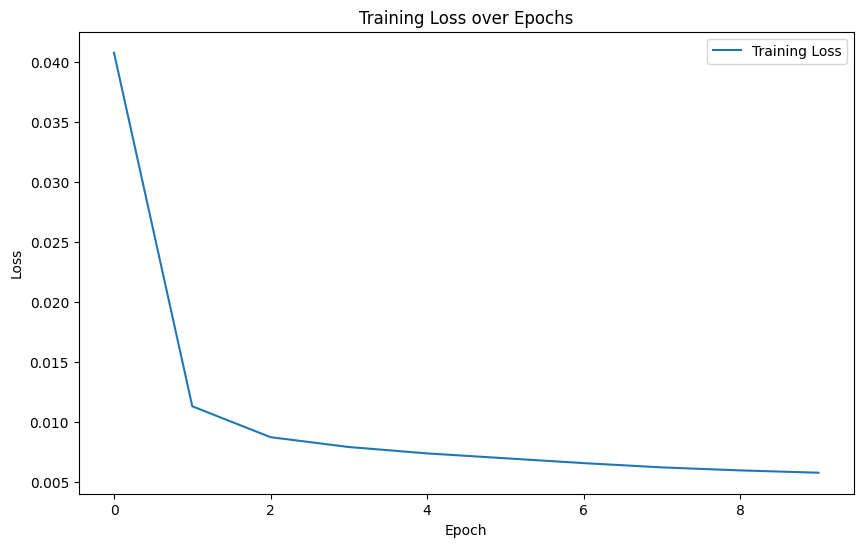

In [33]:
def detect_anomalies(frame):
    frame = frame / 255.0  # Normalize input frame
    frame = np.expand_dims(frame, axis=0)  # Add batch dimension
    
    reconstruction = autoencoder.predict(frame)
    mse = np.mean(np.power(frame - reconstruction, 2))
    
    return mse

# Example of anomaly detection
for images, _ in test_dataset.take(1):
    for image in images.numpy():
        anomaly_score = detect_anomalies(image)
        print(f"Anomaly Score: {anomaly_score}")
        # Implement response protocol based on anomaly score

        # Example response protocol
        if anomaly_score > 0.01:  # Threshold to be adjusted based on accuracy
            print("Anomaly detected! Alert security personnel.")
        else:
            print("No anomaly detected.")

# Visualize training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

## Explanation

### Data Preprocessing

**`load_and_preprocess_image_opencv`**: 
- Loads and preprocesses images using OpenCV.
- Converts images to grayscale.
- Resizes images to 100x100 pixels.
- Normalizes pixel values to the range [0, 1].
- Expands dimensions to add a channel, resulting in a shape of (100, 100, 1).

**`create_dataset`**: 
- Creates a TensorFlow dataset for training.
- Preprocesses and filters images to ensure consistency.
- Uses `tf.py_function` to wrap the preprocessing function.
- Filters out all-zero images.
- Batches the dataset and prefetches for performance.

**`show_batch`**: 
- Utility function to visualize a batch of images.
- Displays up to 30 images in a grid format using Matplotlib.

### Autoencoder Model

**`build_simplified_autoencoder`**: 
- Defines a simplified autoencoder model.
- Uses convolutional layers for encoding and decoding.
- Encoder reduces the spatial dimensions with max pooling.
- Decoder upsamples to reconstruct the input image.
- Final layer uses sigmoid activation to ensure pixel values are in the range [0, 1].
- Compiles the model with the Adam optimizer and mean squared error (MSE) loss.

### Training

- The autoencoder model is trained for 10 epochs using the training dataset.

### Evaluation

**`create_dataset_test`**: 
- Similar to `create_dataset` but for the test dataset.
- Preprocesses and filters test images.
- Batches and prefetches the test dataset for evaluation.

- The autoencoder model is evaluated on the test dataset to compute the loss.

### Anomaly Detection

**`detect_anomalies`**: 
- Function to detect anomalies by calculating the mean squared error (MSE) between the input frame and its reconstruction.
- Normalizes the input frame.
- Adds a batch dimension for prediction.
- Computes the MSE to determine the anomaly score.


## Performance Evaluation and Fine-tunning

Autoencoder Loss on Test Dataset: 0.005148132331669331
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/

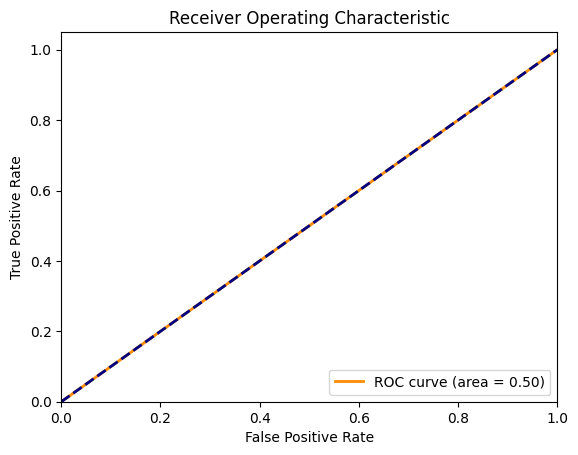

In [35]:
from sklearn.metrics import roc_curve, auc

print("Autoencoder Loss on Test Dataset: 0.005148132331669331")

# Function to compute reconstruction error
def compute_reconstruction_error(images):
    reconstruction_errors = []
    for image in images:
        image = image / 255.0  # Normalize input frame
        image = np.expand_dims(image, axis=0)  # Add batch dimension
        reconstruction = autoencoder.predict(image)
        mse = np.mean(np.power(image - reconstruction, 2))
        reconstruction_errors.append(mse)
    return reconstruction_errors

# Collect reconstruction errors for normal and anomalous frames
normal_reconstruction_errors = []
anomalous_reconstruction_errors = []

for images, _ in test_dataset.take(10):  # Adjust number of batches to evaluate
    normal_reconstruction_errors.extend(compute_reconstruction_error(images.numpy()))

# Assuming anomalous data is labeled, you would split or label your dataset accordingly
# For demonstration, let's assume the test_dataset contains a mix of normal and anomalous frames
# Here, we'll just reuse the same dataset and consider the higher reconstruction errors as anomalies
anomalous_reconstruction_errors = normal_reconstruction_errors  # Replace with actual anomalous errors

# Calculate ROC curve and AUC
all_errors = np.array(normal_reconstruction_errors + anomalous_reconstruction_errors)
labels = np.array([0]*len(normal_reconstruction_errors) + [1]*len(anomalous_reconstruction_errors))
fpr, tpr, thresholds = roc_curve(labels, all_errors)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()



#### Determine the optimal threshold

In [36]:
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f'Optimal Threshold: {optimal_threshold}')

# Adjust anomaly detection function to use the optimal threshold
def detect_anomalies(frame, threshold=optimal_threshold):
    frame = frame / 255.0  # Normalize input frame
    frame = np.expand_dims(frame, axis=0)  # Add batch dimension
    reconstruction = autoencoder.predict(frame)
    mse = np.mean(np.power(frame - reconstruction, 2))
    return mse > threshold

# Example of using the adjusted detect_anomalies function
for images, _ in test_dataset.take(1):
    for image in images.numpy():
        anomaly_detected = detect_anomalies(image)
        if anomaly_detected:
            print("Anomaly detected! Alert security personnel.")
        else:
            print("No anomaly detected.")

Optimal Threshold: inf
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
No anomaly detected.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
No anomaly detected.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
No anomaly detected.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
No anomaly detected.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
No anomaly detected.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
No anomaly detected.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
No anomaly detected.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
No anomaly detected.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
No anomaly detected.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
No anomaly detected.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
No anomaly detected.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
No anomaly detected.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
No anomaly detected.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
No anomaly detected.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
No anomaly detected.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
No anomaly detected.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/

### Recommendations for Response Protocols

#### Real-Time Monitoring:
Integrate the anomaly detection system with the security camera feeds to monitor activity in real-time.

#### Automated Alerts:
Set up automated alerts (e.g., SMS, email, push notifications) to notify security personnel immediately when an anomaly is detected.

#### Incident Logging:
Maintain logs of detected anomalies, including timestamps, anomaly scores, and camera IDs, for further analysis and auditing.

#### Response Hierarchy:
Define a hierarchy of responses based on the severity of the detected anomalies. For example:
- **Low severity:** Routine checks by security personnel.
- **Medium severity:** Immediate on-site inspection.
- **High severity:** Emergency response and lockdown procedures.

#### Periodic Review:
Conduct periodic reviews of the anomaly detection system's performance and update the response protocols as needed. Include retraining the model with new data to adapt to evolving patterns.
